In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import sys 
#pahn1: ket noi mysql
DB_HOST = "localhost"
DB_USER = "root"
DB_PASS = "1234567890" 
DB_NAME = "review_crawl"


print("Đang kết nối tới MySQL...")
try:
    db_connection_str = f'mysql+mysqlconnector://{DB_USER}:{DB_PASS}@{DB_HOST}/{DB_NAME}'
    engine = create_engine(db_connection_str) 
    print("Kết nối thành công! Biến 'engine' đã sẵn sàng.")
except Exception as e:
    print(f"LỖI KẾT NỐI: {e}")
    sys.exit() 

sns.set_style("whitegrid")



# PHẦN 2: TẢI DỮ LIỆU T

print("BƯỚC 2: TẢI DỮ LIỆU THÔ (Cả 2 đợt)")

try:
    print(" -> Đang tải Đợt 1 (từ _dot_1)...")
    
    df_products_t7 = pd.read_sql('SELECT * FROM products_dot_7', con=engine)
    
    df_reviews_t7 = pd.read_sql('SELECT * FROM reviews_dot_7', con=engine)
    print("Đợt 1: Tải thành công 2 bảng thô.")

except Exception as e:
    print(f"LỖI KHI TẢI ĐỢT 1: {e}")
    sys.exit() 

try:
    print("\n -> Đang tải Đợt 2 (từ _dot_2)...") 

    df_products_t8 = pd.read_sql('SELECT * FROM products_dot_8', con=engine)
    
    df_reviews_t8 = pd.read_sql('SELECT * FROM reviews_dot_8', con=engine)
    
    print(f" -> df_products_t7: {len(df_products_t7)} hàng")
    print(f" -> df_reviews_t7:  {len(df_reviews_t7)} hàng")
    print(f" -> df_products_t8: {len(df_products_t8)} hàng")
    print(f" -> df_reviews_t8:  {len(df_reviews_t8)} hàng")

except Exception as e:
    print(f"LỖI KHI TẢI ĐỢT 2: {e}")
    sys.exit()

Đang kết nối tới MySQL...
Kết nối thành công! Biến 'engine' đã sẵn sàng.
BƯỚC 2: TẢI DỮ LIỆU THÔ (Cả 2 đợt)
 -> Đang tải Đợt 1 (từ _dot_1)...
Đợt 1: Tải thành công 2 bảng thô.

 -> Đang tải Đợt 2 (từ _dot_2)...
 -> df_products_t7: 92 hàng
 -> df_reviews_t7:  191235 hàng
 -> df_products_t8: 94 hàng
 -> df_reviews_t8:  222651 hàng


In [4]:
print("\nBƯỚC 3 (v2): LỌC (INNER JOIN) VÀ XÓA TRÙNG LẶP")

print(" -> 3.1: Đang dọn dẹp Keys (Link và ID)...")
LINK_COLUMN_NAME = 'link' 


df_products_t7[LINK_COLUMN_NAME] = df_products_t7[LINK_COLUMN_NAME].astype(str).str.strip()
df_products_t7['product_id'] = pd.to_numeric(df_products_t7['product_id'], errors='coerce').fillna(0).astype(int).astype(str)
df_reviews_t7['product_id'] = pd.to_numeric(df_reviews_t7['product_id'], errors='coerce').fillna(0).astype(int).astype(str)


df_products_t8[LINK_COLUMN_NAME] = df_products_t8[LINK_COLUMN_NAME].astype(str).str.strip()
df_products_t8['product_id'] = pd.to_numeric(df_products_t8['product_id'], errors='coerce').fillna(0).astype(int).astype(str)
df_reviews_t8['product_id'] = pd.to_numeric(df_reviews_t8['product_id'], errors='coerce').fillna(0).astype(int).astype(str)
print(" -> 3.1: Dọn dẹp Keys hoàn tất.")

# --- 3.2: Xóa trùng lặp Link (SỬA LỖI) ---
print(" -> 3.2: Đang xóa các link trùng lặp (chỉ giữ lại 1)...")
# Giữ lại 'link' đầu tiên nó thấy
df_products_t7.drop_duplicates(subset=[LINK_COLUMN_NAME], keep='first', inplace=True)
df_products_t8.drop_duplicates(subset=[LINK_COLUMN_NAME], keep='first', inplace=True)
print(f" -> df_products_t7 (sạch): {len(df_products_t7)} hàng")
print(f" -> df_products_t8 (sạch): {len(df_products_t8)} hàng")


# --- 3.3: Tìm danh sách Link chung ---
print(" -> 3.3: Đang tìm các link chung...")
links_t7 = set(df_products_t7[LINK_COLUMN_NAME])
links_t8 = set(df_products_t8[LINK_COLUMN_NAME])

common_links = links_t7.intersection(links_t8)
print(f" -> 3.3: Tìm thấy {len(common_links)} link chung ở cả hai đợt.")

# --- 3.4: Lọc các bảng Products (Bây giờ sẽ khớp) ---
print(" -> 3.4: Đang lọc các bảng Products...")
df_products_t7 = df_products_t7[df_products_t7[LINK_COLUMN_NAME].isin(common_links)].copy()
df_products_t8 = df_products_t8[df_products_t8[LINK_COLUMN_NAME].isin(common_links)].copy()

print(f" -> df_products_t7 (mới): {len(df_products_t7)} hàng")
print(f" -> df_products_t8 (mới): {len(df_products_t8)} hàng")

# --- 3.5: Lọc các bảng Reviews (Bây giờ sẽ hoạt động) ---
print(" -> 3.5: Đang lọc các bảng Reviews...")
valid_ids_t7 = set(df_products_t7['product_id'])
valid_ids_t8 = set(df_products_t8['product_id'])

df_reviews_t7 = df_reviews_t7[df_reviews_t7['product_id'].isin(valid_ids_t7)].copy()
df_reviews_t8 = df_reviews_t8[df_reviews_t8['product_id'].isin(valid_ids_t8)].copy()

print(f" -> df_reviews_t7 (mới): {len(df_reviews_t7)} hàng")
print(f" -> df_reviews_t8 (mới): {len(df_reviews_t8)} hàng")

print("\n. Các bảng đã được đồng bộ.")


BƯỚC 3 (v2): LỌC (INNER JOIN) VÀ XÓA TRÙNG LẶP
 -> 3.1: Đang dọn dẹp Keys (Link và ID)...
 -> 3.1: Dọn dẹp Keys hoàn tất.
 -> 3.2: Đang xóa các link trùng lặp (chỉ giữ lại 1)...
 -> df_products_t7 (sạch): 92 hàng
 -> df_products_t8 (sạch): 87 hàng
 -> 3.3: Đang tìm các link chung...
 -> 3.3: Tìm thấy 87 link chung ở cả hai đợt.
 -> 3.4: Đang lọc các bảng Products...
 -> df_products_t7 (mới): 87 hàng
 -> df_products_t8 (mới): 87 hàng
 -> 3.5: Đang lọc các bảng Reviews...
 -> df_reviews_t7 (mới): 181999 hàng
 -> df_reviews_t8 (mới): 205719 hàng

. Các bảng đã được đồng bộ.


In [5]:
# BƯỚC 4: TẠO DATAFRAME TỔNG HỢP (df_analysis)

#  gộp dựa trên 'link' 



#laycuabang7
products_t7_simple = df_products_t7[
    ['link', 'product_id', 'title', 'avg_rate', 'review_count']
].copy()

# Đổi tên cột để chuẩn bị gộp
products_t7_simple = products_t7_simple.rename(columns={
    'avg_rate': 'avg_rate_t7',
    'review_count': 'review_count_7'
})

# --- 4.2: Chuẩn bị bảng T8 ---
# Lấy các cột bạn cần từ T8 (chỉ cần 'link' và 'review_count')
products_t8_simple = df_products_t8[
    ['link', 'review_count']
].copy()

# Đổi tên cột
products_t8_simple = products_t8_simple.rename(columns={
    'review_count': 'review_count_8'
})

# Merge T7 và T8
df_analysis = pd.merge(products_t7_simple, products_t8_simple, on='link', how='inner')
print(f"     Gộp bảng hoàn tất! 'df_analysis' có {len(df_analysis)} hàng.")

#  Tính toán chênh lệch 
print(" -> 4.4: Đang tính 'review_count_diff'...")
df_analysis['review_count_diff'] = df_analysis['review_count_8'] - df_analysis['review_count_7']
print("     Đã tính xong độ chênh lệch review.")

# --- HOÀN TẤT ---
print("\nBƯỚC 4 HOÀN TẤT!")
print("     DataFrame 'df_analysis' đã sẵn sàng (5 dòng đầu):")

# Hiển thị các cột cuối cùng
final_columns = [
    'product_id',  # (Sẽ là ID từ Đợt 7)
    'title', 
    'link', 
    'avg_rate_t7', 
    'review_count_7', 
    'review_count_8', 
    'review_count_diff'
]
print(df_analysis[final_columns].head())

     Gộp bảng hoàn tất! 'df_analysis' có 87 hàng.
 -> 4.4: Đang tính 'review_count_diff'...
     Đã tính xong độ chênh lệch review.

BƯỚC 4 HOÀN TẤT!
     DataFrame 'df_analysis' đã sẵn sàng (5 dòng đầu):
  product_id                                              title  \
0          1  ((X) Sao Nhựa Và Sang Trọng Nút Dép Nút Trang ...   
1          2  (Form to đặt lùi 1 size) Giày sandal gắn hoạ t...   
2          3  (FREE-SHIP) Dép lê DSQ Cao Cấp, Dòng Dép Lê Qu...   
3          4  (FREE-SHIP) Dép Nam Cao Cấp, Dòng Dép Lê Quai ...   
4          5  (Lùi 1 size) Dép Rabbit Town quai dán xé cute ...   

                                                link  avg_rate_t7  \
0  https://shopee.vn/((X)-Sao-Nh%E1%BB%B1a-V%C3%A...       4.0000   
1  https://shopee.vn/(Form-to-%C4%91%E1%BA%B7t-l%...       4.5182   
2  https://shopee.vn/(FREE-SHIP)-D%C3%A9p-l%C3%AA...       4.6521   
3  https://shopee.vn/(FREE-SHIP)-D%C3%A9p-Nam-Cao...       4.5010   
4  https://shopee.vn/(L%C3%B9i-1-size)-D%C3%A9p

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4716\3234690442.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4716\3234690442.py:15: UserWarning: Glyph 12300 (\N{LEFT CORNER BRACKET}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4716\3234690442.py:15: UserWarning: Glyph 12301 (\N{RIGHT CORNER BRACKET}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4716\3234690442.py:15: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4716\3234690442.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\LENOVO\App

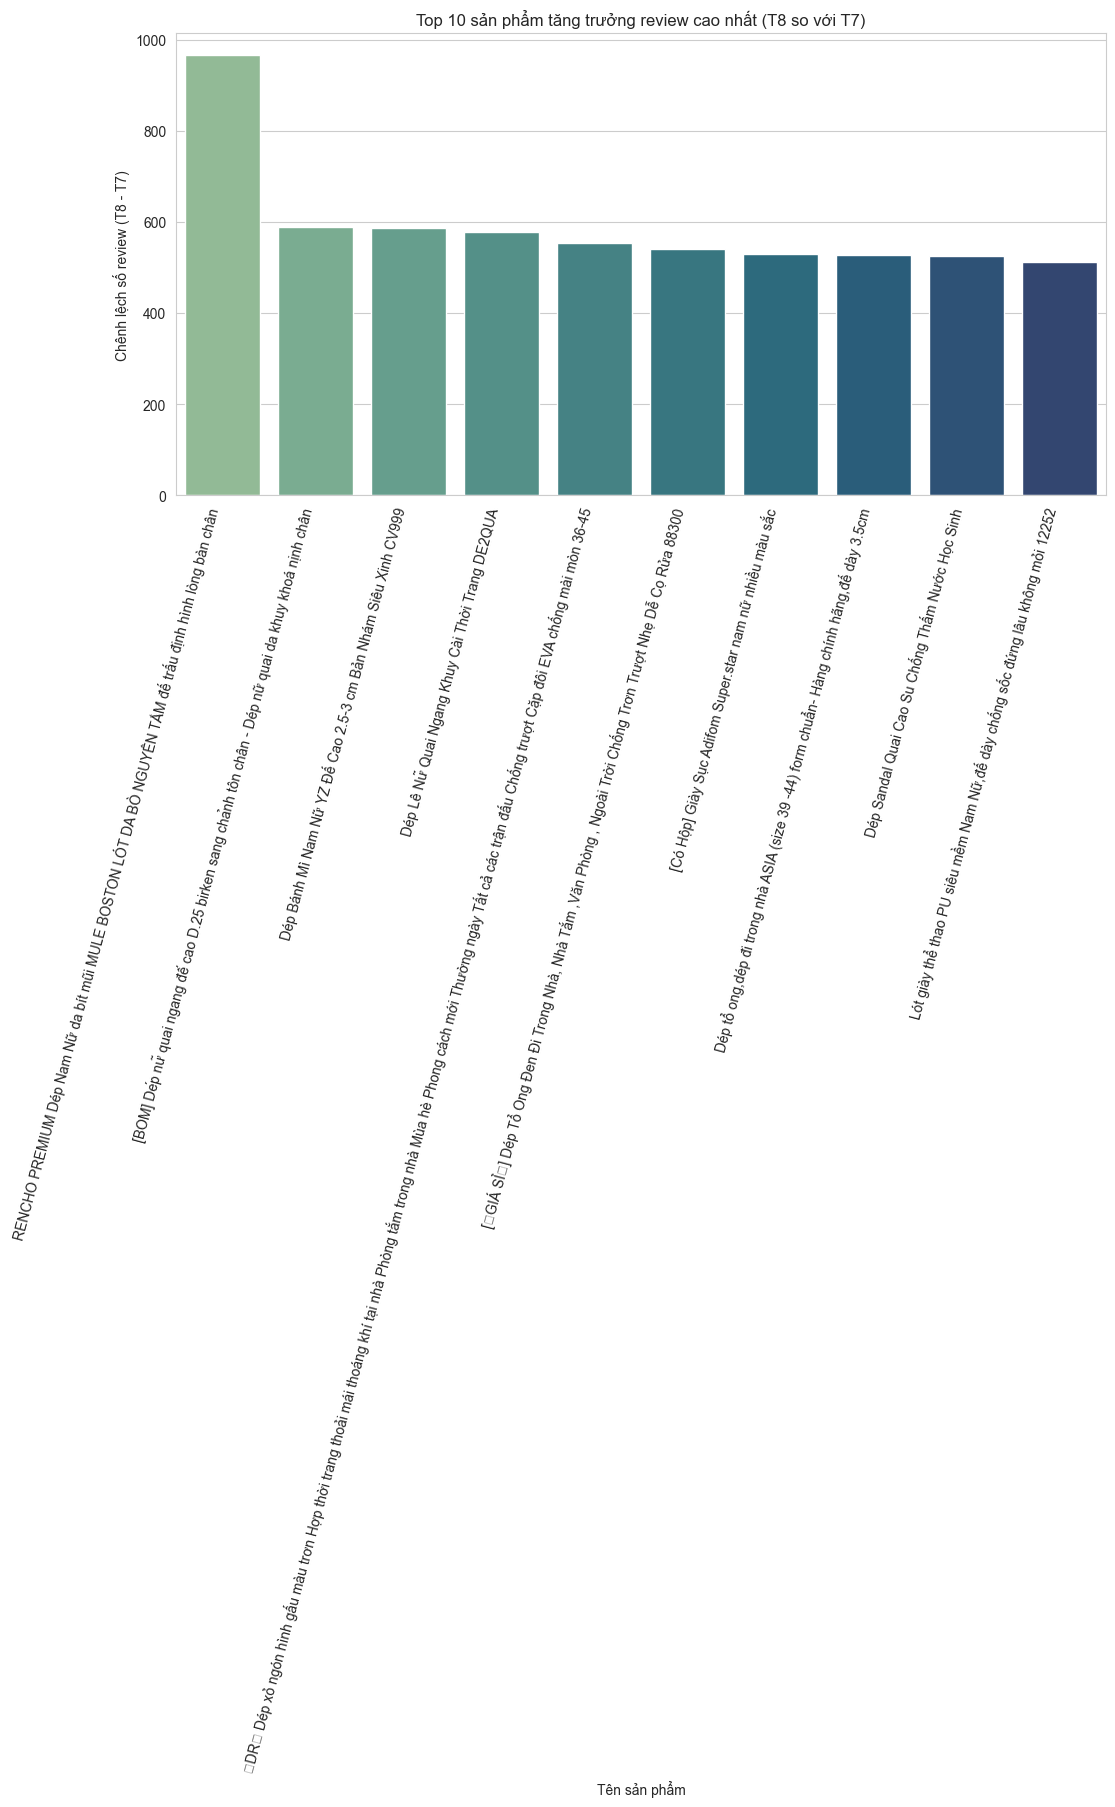

In [6]:
# --- TOP 10 sản phẩm có tăng trưởng review cao nhất ---
top10_increase = df_analysis.nlargest(10, 'review_count_diff')

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top10_increase,
    x='title',
    y='review_count_diff',
    palette='crest'
)
plt.title("Top 10 sản phẩm tăng trưởng review cao nhất (T8 so với T7)")
plt.xlabel("Tên sản phẩm")
plt.ylabel("Chênh lệch số review (T8 - T7)")
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.show()


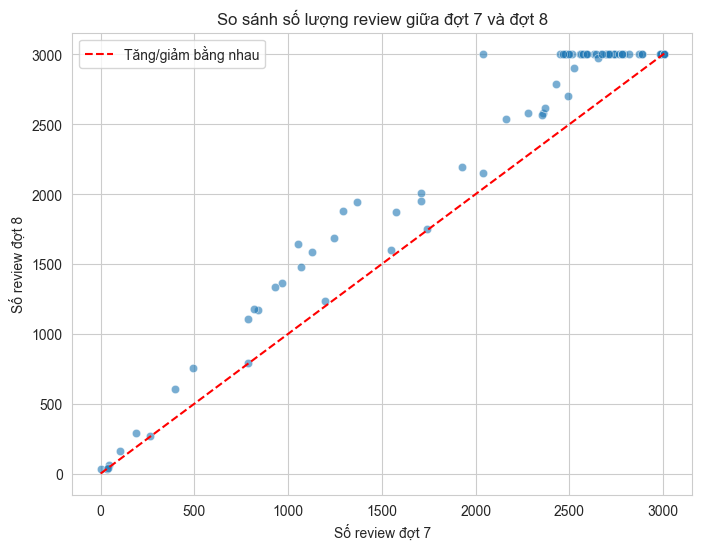

In [7]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_analysis,
    x='review_count_7',
    y='review_count_8',
    alpha=0.6
)
plt.title("So sánh số lượng review giữa đợt 7 và đợt 8")
plt.xlabel("Số review đợt 7")
plt.ylabel("Số review đợt 8")

# Thêm đường chéo y=x để dễ thấy tăng/giảm
max_val = max(df_analysis['review_count_7'].max(), df_analysis['review_count_8'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Tăng/giảm bằng nhau')
plt.legend()
plt.show()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4716\3258817961.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


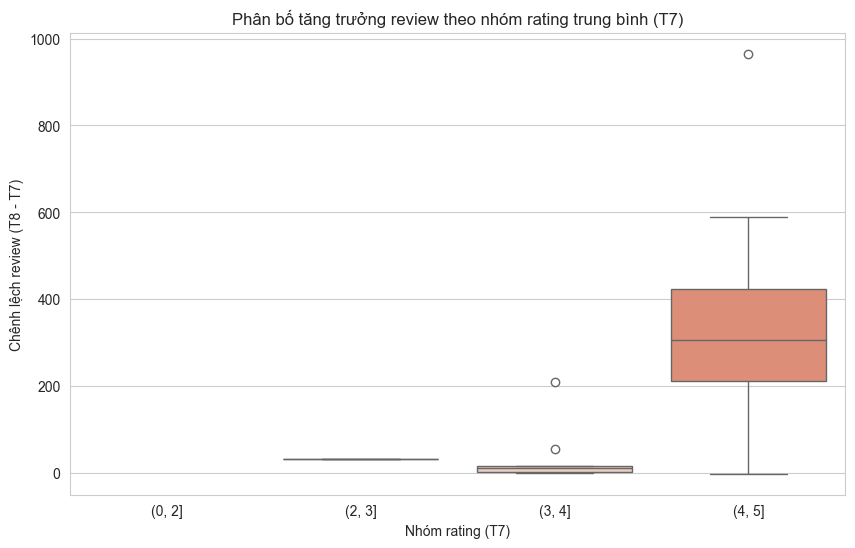

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_analysis,
    x=pd.cut(df_analysis['avg_rate_t7'], bins=[0,2,3,4,5]),
    y='review_count_diff',
    palette='coolwarm'
)
plt.title("Phân bố tăng trưởng review theo nhóm rating trung bình (T7)")
plt.xlabel("Nhóm rating (T7)")
plt.ylabel("Chênh lệch review (T8 - T7)")
plt.show()
